### Лабораторная работа №6: Градиентный бустинг 
##### Выполнил студент группы: 6131-010402D Павлов Владислав

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as pltx

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, mean_absolute_error, mean_squared_error, 
                             r2_score, classification_report)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor, DMatrix
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from warnings import filterwarnings

import shap
filterwarnings("ignore")


### 1. Загрузка датасета

In [2]:
df = pd.read_csv("bank-full.csv")

### 2. Датасет и подготовка данных:
### 2.1 Привести описание датасета.

#### Датасет содержит данные о звоннках маркетинговой компании для банковского учреждения 
#### Цель - прогнозирование подписания продукта

| Признак               | Описание                                         | Единицы измерения | Тип данных |
|:----------------------|:-------------------------------------------------|:------------------|:-----------|
| Age               | Возраст клиента                                  | Годы              | Числовой   |
| Job                | Профессия клиента                                | -                 | Категориальный |
| Martial    | Семейное положение клиента                       | -                 | Категориальный |
| Education           | Уровень образования клиента                      | -                 | Категориальный |
| Default                | Имеет ли клиент задолженность по кредиту?        | -                 | Категориальный |
| Housing                 | Имеет ли клиент ипотечный кредит                 | -                 | Категориальный |
| Loan                  | Имеет ли клиент личный займ                      | -                 | Категориальный |
| Balance                | Индивидуальный баланс клиента                    | Дирхам            | Числовой   |
| Contact               | Тип коммуникации                                 | -                 | Категориальный |
| Month                 | Последний месяц контакта в году                 | -                 | Категориальный |
| Day                  | Последний день недели контакта                  | -                 | Категориальный |
| Duration     | Продолжительность последнего контакта, в секундах| Секунды           | Числовой   |
| Campaign              | Количество контактов в рамках данной кампании   | -                 | Числовой   |
| Pdays                 | Количество дней с момента последнего контакта в предыдущей кампании | Дни | Числовой   |
| Previos            | Количество контактов перед данной кампанией для данного клиента | - | Числовой   |
| Poutcome  | Результат предыдущей маркетинговой кампании     | -                 | Категориальный |
| Y                     | Подписал ли клиент срочный депозит               | -                 | Категориальный |


In [3]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


### 2.2 Осуществить предобработку данных (избавиться от null, убрать некоторые признаки и т.п.) - "подчистить данные".

In [5]:
# проверка на NAN
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
droped_features = ["contact", "month"]
df_droped = df.drop(columns= droped_features, axis = 1)
df_droped.head() # набор данных без кодирования категориальных признаков

,age,job,marital,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,5,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,5,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,5,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,5,198,1,-1,0,unknown,no


In [8]:

df_dropped = df_droped.copy()

binary_features = ['job', 'marital', 'education', 'poutcome','default', 'housing', 'loan', "y"]
label_encode = LabelEncoder()
encoded_features = {}

for feature in binary_features:
    encoded_features[feature] = label_encode.fit_transform(df_dropped[feature])
    df_dropped[feature] = encoded_features[feature]

df_dropped.head() # с кодированием категориальных признаков 



,age,job,marital,education,default,balance,housing,loan,day,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,5,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,5,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,5,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,5,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,5,198,1,-1,0,3,0


### 2.3 Нормализовать численные данные.

In [9]:
# для кодированных данных
x_enc = df_dropped.drop("y", axis = 1)
y_enc = df_dropped["y"]
x_cat = df_droped.drop(["y"], axis = 1)
y_cat = df_droped["y"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_enc)
x_scaled_df = pd.DataFrame(x_scaled, columns = x_enc.columns)

### 2.4 Разбить выборку на обучающую и тестовую

In [10]:
x_enc_train, x_enc_test, y_enc_train, y_enc_test = train_test_split(x_scaled_df, y_enc, test_size= 0.3, random_state= 42)

x_cat_train = x_cat.loc[x_enc_train.index]
x_cat_test = x_cat.loc[x_enc_test.index]
y_cat_train = y_cat.loc[y_enc_train.index]
y_cat_test = y_cat.loc[y_enc_test.index]


### 3. Для каждого из классификаторов (AdaBoost, GradientBoostingClassifier, XGBoost, CatBoost):

### 3.1  С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели, использовать выборки с закодированными категориальными признаками.

#### AdaBoost: подбор гиперпараметров

### Оценка работы классификатора на стандартных гиперпараметрах

In [56]:
ada = AdaBoostClassifier(n_estimators= 50, learning_rate= 1.0, random_state= 0)
ada.fit(x_enc_train, y_enc_train)
y_enc_pred = ada.predict(x_enc_test)
print(classification_report(y_enc_test, y_enc_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.60      0.34      0.43      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.66      0.69     13564
weighted avg       0.88      0.90      0.88     13564



#### Модель на стандартных гиперпараметрах очень хорошо предсказывает класс 0. Класс 1 предсказывает гораздо хуже. Это вызвано дисбалансом классов.
#### Выполним подбор гиперпараметров с помощью GridsearchCV и оценим результаты

In [57]:
adb_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
}

adb_grid_search = GridSearchCV(ada, adb_grid, cv = 5, verbose= 2, n_jobs= -1)
adb_grid_search.fit(x_enc_train, y_enc_train)


Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [59]:
adb_grid_search.best_params_

{'learning_rate': 0.7100000000000001, 'n_estimators': 140}

In [61]:
adb_model = AdaBoostClassifier(n_estimators = 140, learning_rate= 0.71, random_state= 0)
adb_model.fit(x_enc_train, y_enc_train)

adb_pred = adb_model.predict(x_enc_test)
print(classification_report(y_enc_test, adb_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.62      0.33      0.43      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.65      0.69     13564
weighted avg       0.88      0.90      0.88     13564



После подбора гиперпараметров результат, в целом, не изменился. Можно сделать вывод о том, что данная модель хорошо определит класс 0, но с классом 1 проблемы

#### GradientBoosting: подбор гиперпараметров

### Тестирование модели на стандартных гиперпараметрах

In [63]:
gr_boost = GradientBoostingClassifier(n_estimators= 50, learning_rate=0.4, max_depth=6, random_state= 42)
gr_boost.fit(x_enc_train, y_enc_train)

gr_boost_pred = gr_boost.predict(x_enc_test)
print(classification_report(y_enc_test, gr_boost_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11966
           1       0.59      0.40      0.47      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.68      0.71     13564
weighted avg       0.88      0.90      0.89     13564



### В результате модель градиентного бустинга выдает результаты примерно равные модели AdaBoost. Выполним подбор гиперпараметров

In [64]:
grad_boost_grid = {
    'n_estimators': [100, 300, 500],  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.1, 1.1, 0.1),  # скорость обучения
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
}

grad_boost_grid_search = GridSearchCV(gr_boost, grad_boost_grid, cv = 5, verbose= 2, n_jobs= -1)
grad_boost_grid_search.fit(x_enc_train, y_enc_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(learning_rate=0.4,
                                                  max_depth=6, n_estimators=50,
                                                  random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500]},
             verbose=2)

In [65]:
grad_boost_grid_search.best_params_

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

In [66]:
gr_boost_ = GradientBoostingClassifier(n_estimators= 100, learning_rate=0.2, max_depth=3, random_state= 42)
gr_boost_.fit(x_enc_train, y_enc_train)

gr_boost_pred_ = gr_boost.predict(x_enc_test)
print(classification_report(y_enc_test, gr_boost_pred_))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11966
           1       0.59      0.40      0.47      1598

    accuracy                           0.90     13564
   macro avg       0.76      0.68      0.71     13564
weighted avg       0.88      0.90      0.89     13564



#### результат не изменился

#### XGBoost: подбор гиперпараметров

#### Тестирование модели на стандартных гиперпараметрах

In [70]:
xgbs = XGBClassifier(n_estimators=60, max_depth=3, learning_rate=1)
xgbs.fit(x_enc_train, y_enc_train)

xgb_pred = xgbs.predict(x_enc_test)
print(classification_report(y_enc_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11966
           1       0.58      0.40      0.47      1598

    accuracy                           0.90     13564
   macro avg       0.75      0.68      0.71     13564
weighted avg       0.88      0.90      0.89     13564



In [15]:
xgb_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
    'alpha': [0, 0.1, 0.2, 0.3],  # параметр регуляризации L1
    'lambda': [0, 0.1, 0.2, 0.3]  # параметр регуляризации L2
}

# Создание объекта GridSearchCV
xgb_grid_search = GridSearchCV(xgbs, xgb_grid, cv=5, verbose=2, n_jobs=-1)

# Обучение GridSearchCV на данных
xgb_grid_search.fit(x_enc_train, y_enc_train)


Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'alpha': [0, 0.1, 0.2, 0.3],
                         'lambda': [0, 0.1, 0.2, 0.3],
                         'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [16]:
xgb_grid_search.best_params_

{'alpha': 0,
 'lambda': 0.2,
 'learning_rate': 0.11,
 'max_depth': 5,
 'n_estimators': 120}

In [71]:
xgbs_ = XGBClassifier(n_estimators=120, max_depth=5, learning_rate= 0.11)
xgbs_.fit(x_enc_train, y_enc_train)

xgb_pred_ = xgbs_.predict(x_enc_test)
print(classification_report(y_enc_test, xgb_pred_))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     11966
           1       0.62      0.40      0.49      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.68      0.72     13564
weighted avg       0.89      0.90      0.89     13564



### результат в целом не изменился

#### CatBoost: подбор гиперпараметров

#### Тестирование модели на стандартных гиперпараметрах

In [76]:
catboosting = CatBoostClassifier(n_estimators= 30, l2_leaf_reg= 0.11, learning_rate= 0.4, max_depth= 3)
catboosting.fit(x_enc_train, y_enc_train)

catboosting_pred = catboosting.predict(x_enc_test)
print(classification_report(y_enc_test, catboosting_pred))

0:	learn: 0.4822970	total: 2.95ms	remaining: 85.6ms
1:	learn: 0.3808384	total: 5.9ms	remaining: 82.7ms
2:	learn: 0.3280815	total: 8.79ms	remaining: 79.2ms
3:	learn: 0.2974214	total: 11.8ms	remaining: 76.7ms
4:	learn: 0.2797660	total: 14.5ms	remaining: 72.6ms
5:	learn: 0.2689835	total: 17.5ms	remaining: 69.8ms
6:	learn: 0.2636454	total: 20.3ms	remaining: 66.8ms
7:	learn: 0.2581863	total: 23.2ms	remaining: 63.8ms
8:	learn: 0.2539749	total: 26.2ms	remaining: 61.1ms
9:	learn: 0.2498216	total: 28.9ms	remaining: 57.8ms
10:	learn: 0.2472407	total: 31.8ms	remaining: 55ms
11:	learn: 0.2428337	total: 34.9ms	remaining: 52.3ms
12:	learn: 0.2409519	total: 37.9ms	remaining: 49.5ms
13:	learn: 0.2391950	total: 40.7ms	remaining: 46.5ms
14:	learn: 0.2382911	total: 43.6ms	remaining: 43.6ms
15:	learn: 0.2370244	total: 46.7ms	remaining: 40.8ms
16:	learn: 0.2358808	total: 49.7ms	remaining: 38ms
17:	learn: 0.2350945	total: 52.2ms	remaining: 34.8ms
18:	learn: 0.2343449	total: 54.8ms	remaining: 31.7ms
19:	lear

In [17]:
# Определение сетки параметров для поиска
catboost_grid = {
    'n_estimators': range(10, 151, 10),  # количество деревьев в ансамбле
    'learning_rate': np.arange(0.01, 1, 0.1),  # скорость обучения
    'max_depth': [3, 5, 7],  # максимальная глубина деревьев
    'l2_leaf_reg': [0, 0.1, 0.2, 0.3]  # параметр регуляризации L2
}

# Создание объекта GridSearchCV
catboost_grid_search = GridSearchCV(catboosting, catboost_grid, cv=5, verbose=2, n_jobs=-1)

# Обучение GridSearchCV на данных
catboost_grid_search.fit(x_enc_train, y_enc_train)



Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
0:	learn: 0.6197627	total: 145ms	remaining: 18.7s
1:	learn: 0.5628310	total: 150ms	remaining: 9.62s
2:	learn: 0.5154881	total: 155ms	remaining: 6.57s
3:	learn: 0.4760135	total: 160ms	remaining: 5.04s
4:	learn: 0.4427882	total: 165ms	remaining: 4.12s
5:	learn: 0.4167600	total: 169ms	remaining: 3.5s
6:	learn: 0.3924354	total: 174ms	remaining: 3.06s
7:	learn: 0.3720281	total: 179ms	remaining: 2.73s
8:	learn: 0.3544987	total: 184ms	remaining: 2.47s
9:	learn: 0.3393272	total: 189ms	remaining: 2.27s
10:	learn: 0.3259681	total: 194ms	remaining: 2.09s
11:	learn: 0.3151260	total: 198ms	remaining: 1.95s
12:	learn: 0.3046322	total: 203ms	remaining: 1.83s
13:	learn: 0.2961210	total: 208ms	remaining: 1.72s
14:	learn: 0.2886356	total: 212ms	remaining: 1.63s
15:	learn: 0.2818033	total: 217ms	remaining: 1.55s
16:	learn: 0.2759665	total: 222ms	remaining: 1.47s
17:	learn: 0.2703390	total: 226ms	remaining: 1.41s
18:	learn: 0.2659841	total: 

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000250DA1D9E40>,
             n_jobs=-1,
             param_grid={'l2_leaf_reg': [0, 0.1, 0.2, 0.3],
                         'learning_rate': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91]),
                         'max_depth': [3, 5, 7],
                         'n_estimators': range(10, 151, 10)},
             verbose=2)

In [18]:
catboost_grid_search.best_params_

{'l2_leaf_reg': 0.2,
 'learning_rate': 0.11,
 'max_depth': 7,
 'n_estimators': 130}

In [74]:
catboosting_ = CatBoostClassifier(n_estimators= 130, l2_leaf_reg= 0.2, learning_rate= 0.11, max_depth= 7)
catboosting_.fit(x_enc_train, y_enc_train)

catboosting_pred_ = catboosting_.predict(x_enc_test)
print(classification_report(y_enc_test, catboosting_pred_))

0:	learn: 0.6197627	total: 5.69ms	remaining: 734ms
1:	learn: 0.5628310	total: 10.8ms	remaining: 690ms
2:	learn: 0.5154881	total: 16ms	remaining: 678ms
3:	learn: 0.4760135	total: 20.9ms	remaining: 659ms
4:	learn: 0.4427882	total: 25.8ms	remaining: 644ms
5:	learn: 0.4167600	total: 30.6ms	remaining: 633ms
6:	learn: 0.3924354	total: 35.8ms	remaining: 629ms
7:	learn: 0.3720281	total: 40.9ms	remaining: 623ms
8:	learn: 0.3544987	total: 46ms	remaining: 619ms
9:	learn: 0.3393272	total: 51ms	remaining: 613ms
10:	learn: 0.3259681	total: 56.3ms	remaining: 609ms
11:	learn: 0.3151260	total: 61.6ms	remaining: 605ms
12:	learn: 0.3046322	total: 67.1ms	remaining: 604ms
13:	learn: 0.2961210	total: 72.4ms	remaining: 600ms
14:	learn: 0.2886356	total: 77.4ms	remaining: 593ms
15:	learn: 0.2818033	total: 82.7ms	remaining: 589ms
16:	learn: 0.2759665	total: 87.5ms	remaining: 582ms
17:	learn: 0.2703390	total: 92.8ms	remaining: 577ms
18:	learn: 0.2659841	total: 97.4ms	remaining: 569ms
19:	learn: 0.2617038	total: 

#### После оптимизации гиперпараметров, результат по сравнению на стандартных гиперпараметрах не изменился. НО, по сравнению с предыдущими моделями, CatBoost выдал немного лучше предсказания для класс 1

In [19]:
ada_best = AdaBoostClassifier(learning_rate= 0.71, n_estimators= 140)
ada_best.fit(x_enc_train, y_enc_train)

grad_best = GradientBoostingClassifier(learning_rate= 0.11, max_depth= 5, n_estimators= 60)
grad_best.fit(x_enc_train, y_enc_train)

xgb_best = XGBClassifier(alpha = 0, reg_lambda = 0.2, learning_rate = 0.11, max_depth = 5, n_estimators = 120)
xgb_best.fit(x_enc_train, y_enc_train)

cat_boost_best = CatBoostClassifier(l2_leaf_reg=0.2, learning_rate= 0.11, max_depth= 7, n_estimators= 130)
cat_boost_best.fit(x_enc_train, y_enc_train)

0:	learn: 0.6197627	total: 5.94ms	remaining: 767ms
1:	learn: 0.5628310	total: 11.3ms	remaining: 725ms
2:	learn: 0.5154881	total: 16.8ms	remaining: 713ms
3:	learn: 0.4760135	total: 21.9ms	remaining: 689ms
4:	learn: 0.4427882	total: 27.2ms	remaining: 681ms
5:	learn: 0.4167600	total: 32.4ms	remaining: 669ms
6:	learn: 0.3924354	total: 37.8ms	remaining: 664ms
7:	learn: 0.3720281	total: 43.3ms	remaining: 660ms
8:	learn: 0.3544987	total: 48.4ms	remaining: 651ms
9:	learn: 0.3393272	total: 53.8ms	remaining: 646ms
10:	learn: 0.3259681	total: 59.1ms	remaining: 640ms
11:	learn: 0.3151260	total: 64.6ms	remaining: 635ms
12:	learn: 0.3046322	total: 69.8ms	remaining: 628ms
13:	learn: 0.2961210	total: 74.7ms	remaining: 619ms
14:	learn: 0.2886356	total: 79.5ms	remaining: 609ms
15:	learn: 0.2818033	total: 84.2ms	remaining: 600ms
16:	learn: 0.2759665	total: 89ms	remaining: 591ms
17:	learn: 0.2703390	total: 94.1ms	remaining: 585ms
18:	learn: 0.2659841	total: 98.6ms	remaining: 576ms
19:	learn: 0.2617038	tot

### 3.2 Обучить модели XGBoost и CatBoost с найденными гиперпараметрами на обучающей выборке с категориальными признаками "как есть".

In [20]:
cat_cols = [var for var in x_cat_train.columns if x_cat_train[var].dtype == 'object']
x_cat_train_cb = x_cat_train.copy()
x_cat_test_cb = x_cat_test.copy()

for col in cat_cols:
    x_cat_train_cb[col] = pd.Categorical(x_cat_train_cb[col])
    x_cat_test_cb[col] = pd.Categorical(x_cat_test_cb[col])

train_data_cat_as_is = Pool(data=x_cat_train_cb, label=y_cat_train, cat_features=cat_cols)
test_data_cat_as_is = Pool(data=x_cat_test_cb, label=y_enc_test, cat_features=cat_cols)

xgb_best_cat = XGBClassifier(alpha = 0, reg_lambda = 0.2, learning_rate = 0.11, max_depth = 5, n_estimators = 120, enable_categorical = True)
xgb_best_cat.fit(x_cat_train_cb, y_enc_train)


catboost_best_cat = CatBoostClassifier(l2_leaf_reg=0.2, learning_rate= 0.11, max_depth= 7, n_estimators= 130)
catboost_best_cat.fit(train_data_cat_as_is)

0:	learn: 0.6222273	total: 44.9ms	remaining: 5.79s
1:	learn: 0.5651309	total: 65.6ms	remaining: 4.2s
2:	learn: 0.5182330	total: 86.5ms	remaining: 3.66s
3:	learn: 0.4786983	total: 108ms	remaining: 3.4s
4:	learn: 0.4459738	total: 129ms	remaining: 3.22s
5:	learn: 0.4188532	total: 149ms	remaining: 3.08s
6:	learn: 0.3956209	total: 170ms	remaining: 2.98s
7:	learn: 0.3758529	total: 190ms	remaining: 2.89s
8:	learn: 0.3591381	total: 211ms	remaining: 2.83s
9:	learn: 0.3447135	total: 230ms	remaining: 2.77s
10:	learn: 0.3315610	total: 251ms	remaining: 2.72s
11:	learn: 0.3205996	total: 272ms	remaining: 2.67s
12:	learn: 0.3107539	total: 295ms	remaining: 2.66s
13:	learn: 0.3010791	total: 316ms	remaining: 2.62s
14:	learn: 0.2921670	total: 336ms	remaining: 2.58s
15:	learn: 0.2856156	total: 346ms	remaining: 2.47s
16:	learn: 0.2793647	total: 367ms	remaining: 2.44s
17:	learn: 0.2736237	total: 387ms	remaining: 2.41s
18:	learn: 0.2679128	total: 407ms	remaining: 2.38s
19:	learn: 0.2639259	total: 427ms	remain

### 3.3 Итого получить 6 обученных моделей.

In [21]:
print(f"AdaBoost: {ada_best} \n GradientBoost: {grad_best} \n XGBClass_encode: {xgb_best} \n CatBoost_encode: {cat_boost_best} \n XGBC_catt: {xgb_best_cat} \n CatBoost_catt: {catboost_best_cat}")

AdaBoost: AdaBoostClassifier(learning_rate=0.71, n_estimators=140) 
 GradientBoost: GradientBoostingClassifier(learning_rate=0.11, max_depth=5, n_estimators=60) 
 XGBClass_encode: XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=None,
              num_parallel_tree=None, ...) 
 CatBoost_encode: <catboost.core.CatBoostClassifier object at 0x00000250D82

### 3.4 Вывести метрики на тестовом наборе (как минимум classification_report, другие по желанию).

In [22]:
def show_metrics(x_values, y_values, model):
    pred = model.predict(x_values)
    class_rep = classification_report(y_values, pred)
    print(class_rep)


In [23]:
print("AdaBoostClassifier")
ada_metrics = show_metrics(x_enc_test, y_enc_test, ada_best)
print("GradientBoostingClassifier")
grad_metrics = show_metrics(x_enc_test, y_enc_test, grad_best)
print("XGBClassifier with coded")
xgb_code_metrics = show_metrics(x_enc_test, y_enc_test, xgb_best)
print("CatBoostClassifier with coded")
cat_code_metrics = show_metrics(x_enc_test, y_enc_test, cat_boost_best)
print("XGBClassifier as is")
xgb_cat_metrics = show_metrics(x_cat_test_cb, y_enc_test, xgb_best_cat)
print("CatBoostClassifier as is")
cat_cat_metrics = show_metrics(x_cat_test_cb, y_cat_test, catboost_best_cat)


AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.62      0.33      0.43      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.65      0.69     13564
weighted avg       0.88      0.90      0.88     13564

GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.62      0.39      0.48      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.68      0.71     13564
weighted avg       0.89      0.90      0.89     13564

XGBClassifier with coded
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11966
           1       0.62      0.40      0.49      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.69      0.72     13564
wei

*Выводы:*

Модели показали в средем примерно одинаковые результаты, даже с подбором гиперпараметров. Из моделей XGBoost и CatBoost наилучший результат показала модель CatBoost с категориальными признаками, поскольку предсказала класс 1 с точностью = 0.63. Выберем данную модель как лучшую

### 3.5 Сравнить модели, выбрать лучшую

In [77]:
best_model = "CatBoostClassifier with coded"

### 4. Важность признаков:

### 4.1  С использованием shap.TreeExplainer получить SHAP-значения для лучшей модели.

In [78]:
explainer = shap.TreeExplainer(cat_boost_best)
shap_values = explainer.shap_values(x_enc_train)

In [79]:
shap.__version__

'0.45.1'

In [80]:
# shap_values[0,:]
explainer.expected_value

-3.1672671183600305

### 4.2 Построить график shap.plots.force для одного объекта выборки и для среза произвольного размера.

In [82]:
shap.initjs()
shap_fp = shap.plots.force(explainer.expected_value, shap_values[0,:], x_enc_train.iloc[0,:])

from IPython.display import HTML
HTML(f"<div style='background-color: Lavender;'>{shap.getjs() + shap_fp.html()}</div>")

In [83]:
shap.initjs()
shap_fp = shap.plots.force(explainer.expected_value, shap_values[0:100,:], x_enc_train.iloc[0:100,:])

from IPython.display import HTML
HTML(f"<div style='background-color: Lavender;'>{shap.getjs() + shap_fp.html()}</div>")

### 4.3 Построить график shap.plots.bar для одного объекта выборки.

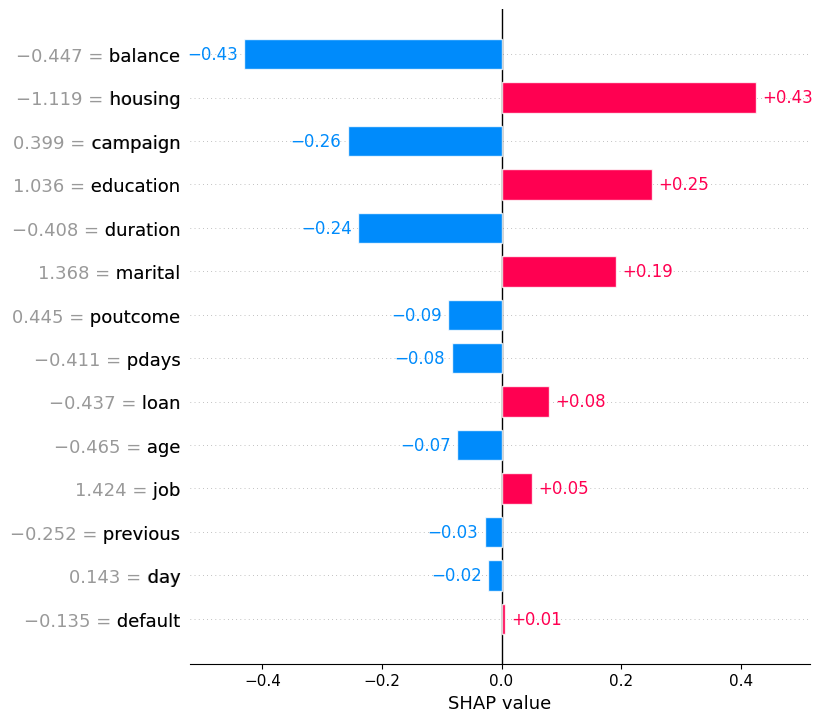

In [84]:
df_shap_values = explainer(x_enc_train)
shap_bp = shap.plots.bar(df_shap_values[0], max_display=x_enc_train.shape[1])

### 4.4 Построить график shap.plots.waterfall для одного объекта выборки.

In [31]:
df_shap_values[0]

.values =
array([-9.2595637e-02, -5.1874857e-02,  1.7980149e-01,  2.4253266e-01,
        1.2644097e-04, -3.1673360e-01,  3.2211551e-01,  6.3192755e-02,
        4.0323068e-03, -8.6581481e-01, -3.1613889e-01, -1.4931075e-01,
       -2.3984717e-02, -1.3485762e-01], dtype=float32)

.base_values =
-2.138023

.data =
array([36, 'technician', 'single', 'tertiary', 'no', 0, 'no', 'no', 17,
       153, 4, -1, 0, 'unknown'], dtype=object)

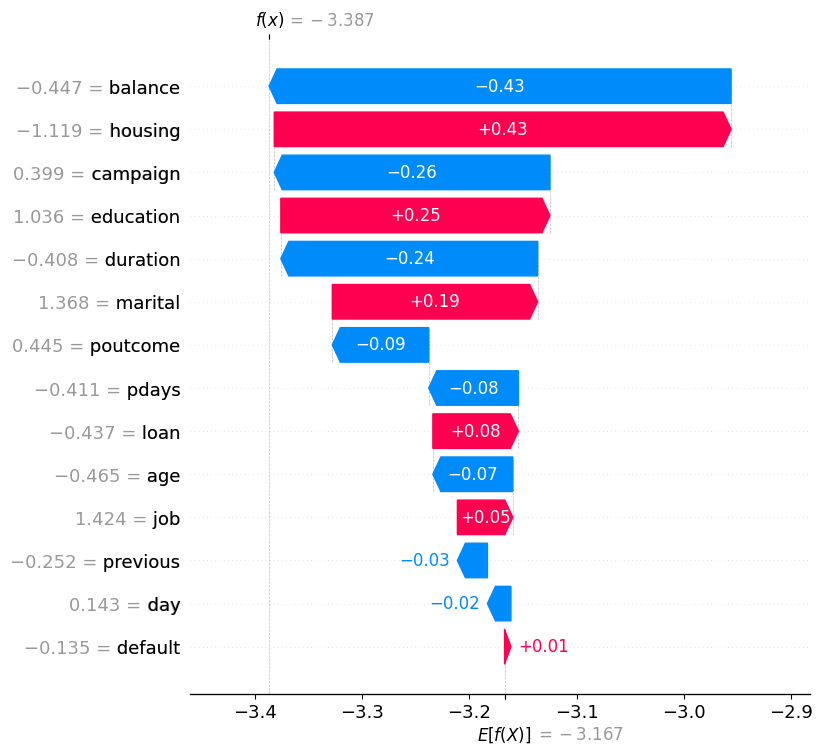

In [85]:
shap.plots.waterfall(df_shap_values[0], max_display=x_enc_train.shape[1])

### 4.5 Построить 2 графика shap.plots.scatter для какого-нибудь признака. На одном раскрасить относительно себя, на втором – относительно другого признака.

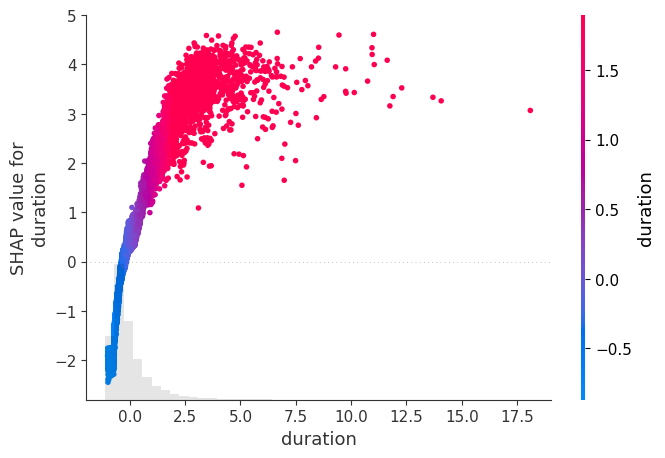

In [86]:
shap.plots.scatter(df_shap_values[:, "duration"], color=df_shap_values[:, "duration"])

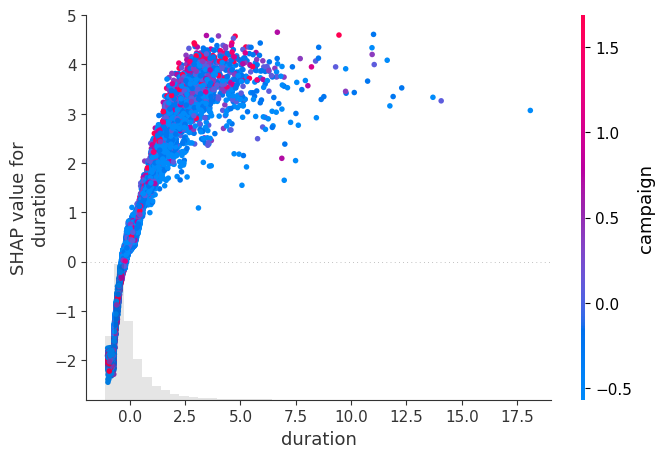

In [87]:
shap.plots.scatter(df_shap_values[:, "duration"], color=df_shap_values[:, "campaign"])

### 4.6 Построить график shap.plots.beeswarm для всех признаков.


<Axes: xlabel='SHAP value (impact on model output)'>

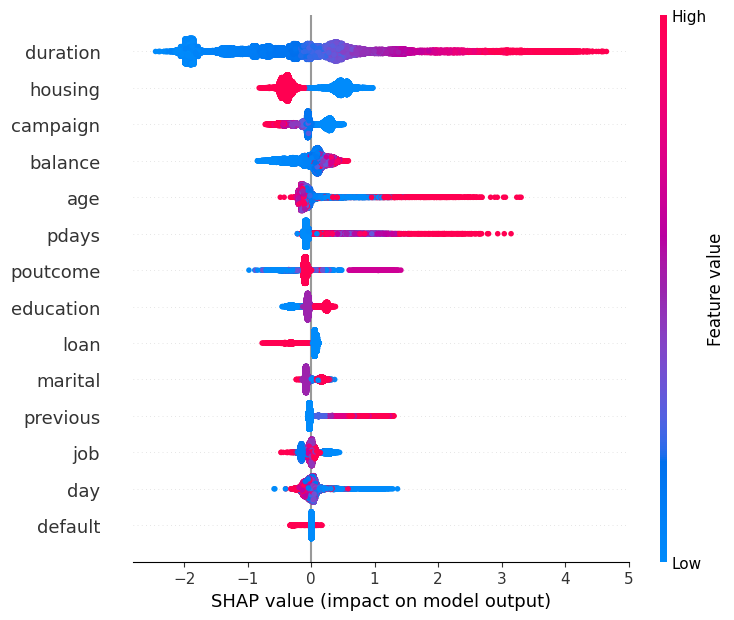

In [88]:
shap.plots.beeswarm(df_shap_values, max_display=x_enc_train.shape[1], show=False)

### 4.7 Построить график shap.plots.bar для всех признаков.

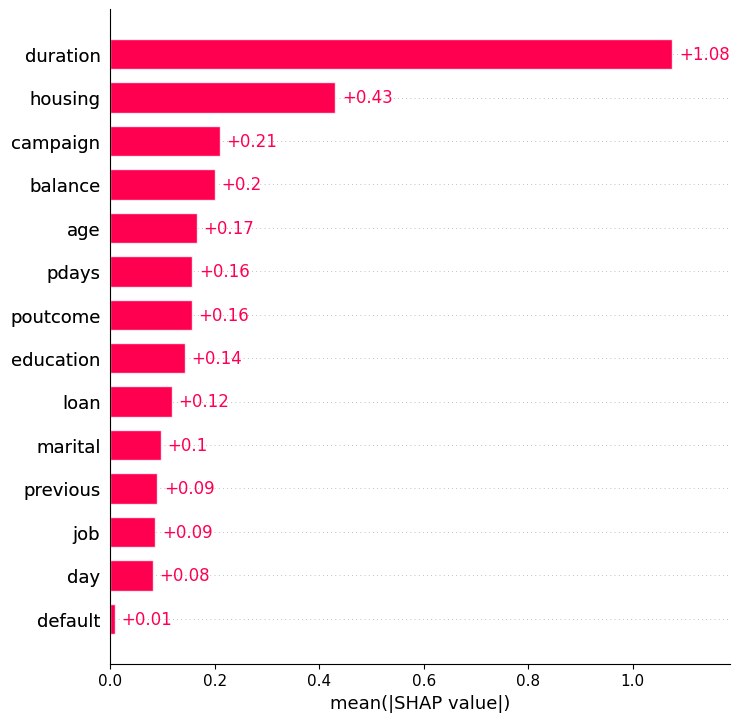

In [89]:
shap_bp = shap.plots.bar(df_shap_values, max_display=x_enc_train.shape[1])

#### Оставим признаки, среднее значение SHAP больше 0.2

### 4.8 На основании двух последних графиков и/или используя feature_importance отфильровать признаки (отразить сформулированные выводы в тексте), переобучить лучшую модель.

In [90]:
filterred_cols = ['balance','campaign', 'housing', "duration"]

In [93]:
cat_boost_best.fit(x_enc_train[filterred_cols], y_enc_train) 

0:	learn: 0.6237865	total: 5.36ms	remaining: 692ms
1:	learn: 0.5698591	total: 8.71ms	remaining: 557ms
2:	learn: 0.5242373	total: 13.5ms	remaining: 571ms
3:	learn: 0.4871762	total: 16.7ms	remaining: 526ms
4:	learn: 0.4554623	total: 21.3ms	remaining: 533ms
5:	learn: 0.4293159	total: 26.2ms	remaining: 542ms
6:	learn: 0.4065683	total: 30.9ms	remaining: 542ms
7:	learn: 0.3877081	total: 35ms	remaining: 534ms
8:	learn: 0.3711032	total: 39.7ms	remaining: 533ms
9:	learn: 0.3573514	total: 44.8ms	remaining: 537ms
10:	learn: 0.3452798	total: 48.4ms	remaining: 524ms
11:	learn: 0.3344254	total: 53.5ms	remaining: 526ms
12:	learn: 0.3254082	total: 58.8ms	remaining: 529ms
13:	learn: 0.3175631	total: 63.9ms	remaining: 529ms
14:	learn: 0.3107190	total: 68.6ms	remaining: 526ms
15:	learn: 0.3053998	total: 72.3ms	remaining: 515ms
16:	learn: 0.3004145	total: 77ms	remaining: 512ms
17:	learn: 0.2961623	total: 81.7ms	remaining: 508ms
18:	learn: 0.2919024	total: 86.5ms	remaining: 505ms
19:	learn: 0.2885957	total

### 4.9 Сравнить метрики до и после фильтрации.

In [96]:
y_predict = cat_boost_best.predict(x_enc_test[filterred_cols])

print(classification_report(y_enc_test, y_predict))


              precision    recall  f1-score   support

           0       0.90      0.98      0.94     11966
           1       0.55      0.20      0.29      1598

    accuracy                           0.89     13564
   macro avg       0.73      0.59      0.61     13564
weighted avg       0.86      0.89      0.86     13564



После фильтрации результат ухудшился. Модель с неотфильтрованными признаками показывала точность предсказания класса 1 = 0.63

### 4.10 Визуализировать полученное дерево решений.

### Построениен дерева решений для модели cat_boost_best до фильтрации признаков

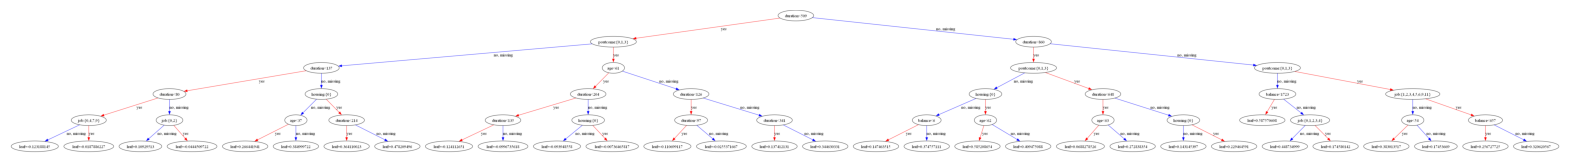

In [98]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Визуализация дерева решений
plt.figure(figsize=(20, 10))
plot_tree(xgb_best_cat, num_trees=0, ax=plt.gca())
plt.show()


### 5. Регрессия

### 5.1 С использованием GridSearchCV/grid_search осуществить подбор гиперпараметра модели линейной регрессии с использованием XGBoost или CatBoost

In [112]:
target_train = x_enc_train["housing"]
x_train_regr = pd.concat([x_enc_train.drop(["housing"], axis=1), y_enc_train], axis=1)
x_train_regr["job"] = pd.Categorical(x_train_regr["job"])

target_test = x_enc_test["housing"]
x_test_regr = pd.concat([x_enc_test.drop(["housing"], axis=1), y_enc_test], axis=1)
x_test_regr["job"] = pd.Categorical(x_test_regr["job"])

In [113]:
print(x_train_regr)

            age       job   marital  education  default   balance      loan  \
10747 -0.464863  1.424008  1.368372   1.036362 -0.13549 -0.447419 -0.436803   
26054  1.418617 -0.714951 -0.275762  -0.300556 -0.13549 -0.383046 -0.436803   
9125   0.476877 -1.020516 -0.275762  -0.300556 -0.13549 -0.447419 -0.436803   
41659  0.006007 -0.103820 -1.919895   1.036362 -0.13549  0.677803 -0.436803   
4443  -0.276515 -1.020516 -0.275762  -0.300556 -0.13549 -0.447419 -0.436803   
...         ...       ...       ...        ...      ...       ...       ...   
11284  0.288529 -0.409385  1.368372  -1.637474 -0.13549 -0.099605 -0.436803   
44732 -1.689124  1.118442  1.368372   1.036362 -0.13549 -0.280574 -0.436803   
38158 -0.653211  1.424008 -1.919895   1.036362 -0.13549 -0.014869 -0.436803   
860   -0.747384  0.201746 -0.275762  -0.300556 -0.13549 -0.393227 -0.436803   
15795 -0.276515 -1.020516 -0.275762  -1.637474 -0.13549 -0.460885 -0.436803   

            day  duration  campaign     pdays  prev

In [114]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Создание объекта регрессора XGBoost
xgb_model = XGBRegressor(enable_categorical=True)

# Определение параметров модели XGBoost
xgb_param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 200, 300]
}

# Поиск оптимальных параметров с помощью кросс-валидации
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5)
xgb_grid_search.fit(x_train_regr, target_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...e,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]})

In [115]:
xgb_grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}

In [45]:
best_reg = XGBRegressor(learning_rate = 0.1, max_depth = 5, n_estimators = 200, enable_categorical = True)

In [46]:
best_reg.fit(x_train_regr, target_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
y_reg_pred = best_reg.predict(x_test_regr)

### 5.2 Вывести метрики MSE, MAE, R2 на тестовом наборе

In [122]:
mse_reg = mean_squared_error(target_test, y_reg_pred)
mae_reg = mean_absolute_error(target_test, y_reg_pred)
r2_reg = r2_score(target_test, y_reg_pred)

print(f"Средняя квадратичная ошибка (MSE): {(mse_reg):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {(mae_reg):.3f}")
print(f"Коэффициент детерминации (R2 score): {(r2_reg):.3f}")

Средняя квадратичная ошибка (MSE): 0.785
Средняя абсолютная ошибка (MAE): 0.787
Коэффициент детерминации (R2 score): 0.215


### 5.3 Переобучить модель на отфильтрованном наборе признаков из пункта 4.

In [123]:
filterred_cols = ['job','poutcome','age','balance','campaign',"duration"]

best_reg.fit(x_train_regr[filterred_cols], target_train)
y_pred_filt = best_reg.predict(x_test_regr[filterred_cols])

### 5.4 Сравнить метрики до и после фильтрации.

In [124]:
mse_reg_filt = mean_squared_error(target_test, y_pred_filt)
mae_reg_filt = mean_absolute_error(target_test, y_pred_filt)
r2_reg_filt = r2_score(target_test, y_pred_filt)


print(f"Средняя квадратичная ошибка (MSE): {(mse_reg):.3f}")
print(f"Средняя абсолютная ошибка (MAE): {(mae_reg):.3f}")
print(f"Коэффициент детерминации (R2 score): {(r2_reg):.3f}")

print(f"Средняя квадратичная ошибка после фильтрации (MSE): {(mse_reg_filt):.3f}")
print(f"Средняя абсолютная ошибка после фильтрации (MAE): {(mae_reg_filt):.3f}")
print(f"Коэффициент детерминации после фильтрации (R2 score): {(r2_reg_filt):.3f}")

Средняя квадратичная ошибка (MSE): 0.785
Средняя абсолютная ошибка (MAE): 0.787
Коэффициент детерминации (R2 score): 0.215
Средняя квадратичная ошибка после фильтрации (MSE): 0.861
Средняя абсолютная ошибка после фильтрации (MAE): 0.848
Коэффициент детерминации после фильтрации (R2 score): 0.139


### Метрики стали хуже